## Flow Diversion

This example simulates unconfined groundwater flow in an aquifer with a high bottom elevation in the center of the aquifer and groundwater flow around a high bottom elevation.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-bump"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-bump-p01a": {
        "newton": "newton",
    },
    "ex-gwf-bump-p01b": {
        "rewet": True,
        "wetfct": 1.0,
        "iwetit": 1,
        "ihdwet": 0,
        "wetdry": 2.0,
    },
    "ex-gwf-bump-p01c": {
        "newton": "newton",
        "cylindrical": True,
    },
}

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 51  # Number of rows
ncol = 51  # Number of columns
xlen = 100.0  # Model length in x-direction ($m$)
ylen = 100.0  # Model length in y-direction ($m$)
top = 25.0  # Top of the model ($m$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/day$)
H1 = 7.5  # Constant head in column 1 and starting head ($m$)
H2 = 2.5  # Constant head in column 51 ($m$)

# Time discretization
tdis_ds = ((1.0, 1, 1.0),)

# Calculate delr, delc, extents, and shape3d
delr = xlen / float(ncol)
delc = ylen / float(nrow)
extents = (0, xlen, 0, ylen)
shape3d = (nlay, nrow, ncol)

# Load the bottom
fname = "bottom.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:9287f9e214147d95e6ed159732079a0b",
)
botm = np.loadtxt(fpath).reshape(shape3d)

# Create a cylinder
cylinder = botm.copy()
cylinder[cylinder < 7.5] = 0.0
cylinder[cylinder >= 7.5] = 20.0

# Constant head boundary conditions
chd_spd = [[0, i, 0, H1] for i in range(nrow)]
chd_spd += [[0, i, ncol - 1, H2] for i in range(nrow)]

# Solver parameters
nouter = 500
ninner = 500
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(
    name,
    newton=False,
    rewet=False,
    cylindrical=False,
    wetfct=None,
    iwetit=None,
    ihdwet=None,
    wetdry=None,
):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    if newton:
        linear_acceleration = "bicgstab"
        newtonoptions = "newton under_relaxation"
    else:
        linear_acceleration = "cg"
        newtonoptions = None

    flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        linear_acceleration=linear_acceleration,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=sim_name,
        newtonoptions=newtonoptions,
        save_flows=True,
    )
    if cylindrical:
        bot = cylinder
    else:
        bot = botm
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=bot,
    )
    if rewet:
        rewet_record = [
            "wetfct",
            wetfct,
            "iwetit",
            iwetit,
            "ihdwet",
            ihdwet,
        ]
    else:
        rewet_record = None
    flopy.mf6.ModflowGwfnpf(
        gwf,
        rewet_record=rewet_record,
        icelltype=1,
        k=k11,
        wetdry=wetdry,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=H1)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties, plotting ranges and contour levels
figure_size = (4, 5.33)
masked_values = (1e30, -1e30)
vmin, vmax = H2, H1
bmin, bmax = 0, 10
vlevels = np.arange(vmin + 0.5, vmax, 1)
blevels = np.arange(bmin + 2, bmax, 2)
bcolor = "black"
vcolor = "black"


def create_figure():
    fig = plt.figure(figsize=figure_size, constrained_layout=False)
    gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
    plt.axis("off")

    # create axes
    ax1 = fig.add_subplot(gs[:5, :])
    ax2 = fig.add_subplot(gs[5:, :])

    # set limits for map figure
    ax1.set_xlim(extents[:2])
    ax1.set_ylim(extents[2:])
    ax1.set_aspect("equal")

    # set limits for legend area
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)

    # get rid of ticks and spines for legend area
    ax2.axis("off")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines["top"].set_color("none")
    ax2.spines["bottom"].set_color("none")
    ax2.spines["left"].set_color("none")
    ax2.spines["right"].set_color("none")
    ax2.patch.set_alpha(0.0)

    axes = [ax1, ax2]

    return fig, axes


def plot_grid(gwf, silent=True):
    with styles.USGSMap() as fs:
        bot = gwf.dis.botm.array
        fig, axes = create_figure()
        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        bot_coll = mm.plot_array(bot, vmin=bmin, vmax=bmax)
        mm.plot_bc("CHD", color="cyan")
        cv = mm.contour_array(
            bot,
            levels=blevels,
            linewidths=0.5,
            linestyles=":",
            colors=bcolor,
        )
        plt.clabel(cv, fmt="%1.0f")
        ax.set_xlabel("x-coordinate, in meters")
        ax.set_ylabel("y-coordinate, in meters")
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="cyan",
            label="Constant Head",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls=":",
            color=bcolor,
            label="Bottom elevation contour, m",
        )
        styles.graph_legend(ax, loc="center", ncol=2)

        cax = plt.axes([0.275, 0.125, 0.45, 0.025])
        cbar = plt.colorbar(
            bot_coll,
            shrink=0.8,
            orientation="horizontal",
            cax=cax,
        )
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Bottom Elevation, $m$")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_results(idx, sim, silent=True):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)
        bot = gwf.dis.botm.array

        if idx == 0:
            plot_grid(gwf, silent=silent)

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # create MODFLOW 6 cell-by-cell budget object
        cobj = gwf.output.budget()

        # extract heads and specific discharge
        head = hobj.get_data(totim=1.0)
        imask = (head > -1e30) & (head <= bot)
        head[imask] = -1e30  # botm[imask]
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            cobj.get_data(text="DATA-SPDIS", totim=1.0)[0],
            gwf,
        )

        # Create figure for simulation
        fig, axes = create_figure()

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        if bot.max() < 20:
            cv = mm.contour_array(
                bot,
                levels=blevels,
                linewidths=0.5,
                linestyles=":",
                colors=bcolor,
                zorder=9,
            )
            plt.clabel(cv, fmt="%1.0f", zorder=9)
        h_coll = mm.plot_array(
            head, vmin=vmin, vmax=vmax, masked_values=masked_values, zorder=10
        )
        cv = mm.contour_array(
            head,
            masked_values=masked_values,
            levels=vlevels,
            linewidths=0.5,
            linestyles="-",
            colors=vcolor,
            zorder=10,
        )
        plt.clabel(cv, fmt="%1.0f", zorder=10)
        mm.plot_bc("CHD", color="cyan", zorder=11)
        mm.plot_vector(qx, qy, normalize=True, color="0.75", zorder=11)
        ax.set_xlabel("x-coordinate, in meters")
        ax.set_ylabel("y-coordinate, in meters")
        styles.remove_edge_ticks(ax)

        # create legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="cyan",
            label="Constant Head",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="$\u2192$",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Normalized specific discharge",
        )
        if bot.max() < 20:
            ax.plot(
                -10000,
                -10000,
                lw=0.5,
                ls=":",
                color=bcolor,
                label="Bottom elevation contour, m",
            )
        ax.plot(
            -10000,
            -10000,
            lw=0.5,
            ls="-",
            color=vcolor,
            label="Head contour, m",
        )
        styles.graph_legend(ax, loc="center", ncol=2)

        cax = plt.axes([0.275, 0.125, 0.45, 0.025])
        cbar = plt.colorbar(h_coll, shrink=0.8, orientation="horizontal", cax=cax)
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Head, $m$", fontsize=9)

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-{idx + 1:02d}.png")

### Running the example

Define a function to run the example scenarios and plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)

Run the flow diversion model with Newton-Raphson and plot simulated heads.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-bump...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 102 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 13 2024 02:36:38 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisiona

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/14 20:07:20
 Elapsed run time:  0.200 Seconds
 
 Normal termination of simulation.
run_models took 210.87 ms


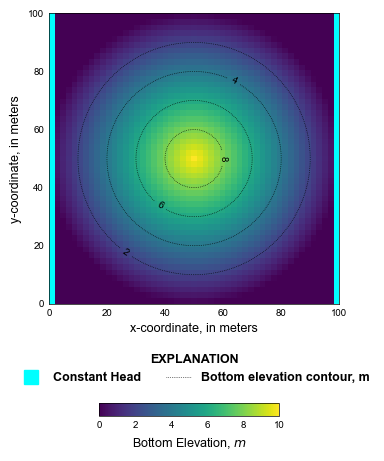

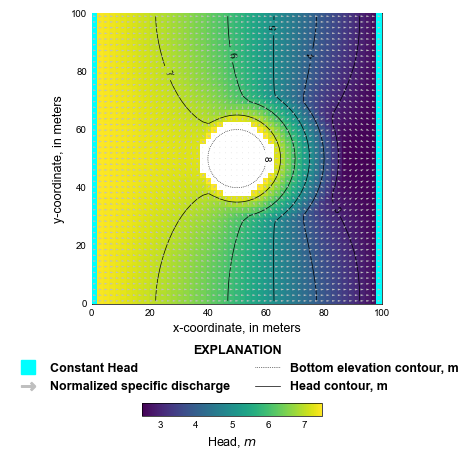

In [6]:
scenario(0, silent=False)

Run the flow diversion model with rewetting and plot simulated heads.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-bump...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 102 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 13 2024 02:36:38 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisiona

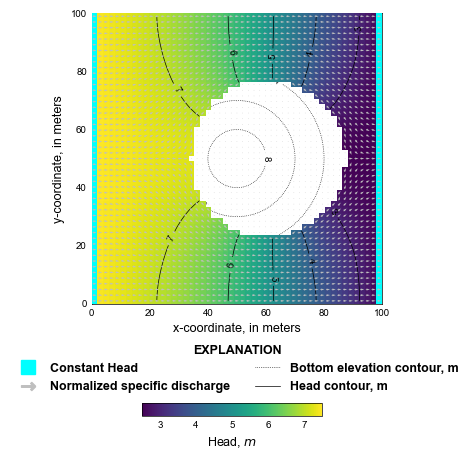

In [7]:
scenario(1, silent=False)

Run the flow diversion model with Newton-Raphson and
cylindrical topography and plot simulated heads.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-bump...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 102 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 13 2024 02:36:38 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisiona

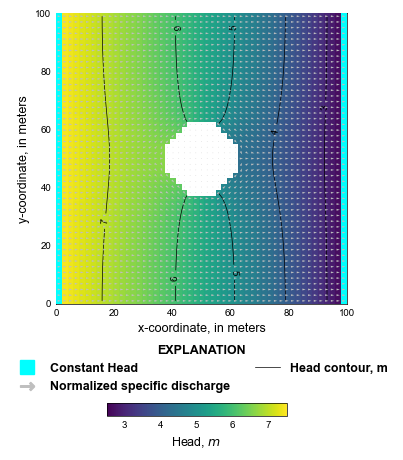

In [8]:
scenario(2, silent=False)